<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/9-unsupervised-learning-techniques/03_clustering_using_dbscan_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Clustering Fundamental

Although most of the applications of Machine Learning today are based on supervised learning (and as a result, this is where most of the investments go to), the vast majority of the available data is unlabeled: we have the input features $X$, but we do not have the labels $y$.

In this notebook we will look at a few more unsupervised learning tasks
and algorithms:

* **Clustering**-The goal is to group similar instances together into clusters.
* **Anomaly detection**-The objective is to learn what “normal” data looks like, and then use that to detect abnormal instances.
* **Density estimation**-This is the task of estimating the probability density function (PDF) of the random process that generated the dataset.

There is no universal definition of what a cluster is: it really depends on the context,
and different algorithms will capture different kinds of clusters. 

Some algorithms look for instances centered around a particular point, called a centroid. 

Others look for continuous regions of densely packed instances: these clusters can take on any shape. 

Some algorithms are hierarchical, looking for clusters of clusters. And the list goes on.

There are two popular clustering algorithms:

* **K-Means**
* **DBSCAN**

And these are the some of their applications, such as nonlinear dimensionality
reduction, semi-supervised learning, and anomaly detection.

##Setup

In [ ]:
# Common imports
import numpy as np
import os
from timeit import timeit

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

from scipy.stats import norm

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.colors import LogNorm
from matplotlib.patches import Polygon

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Let's load iris dataset.

In [ ]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Let's define some ploting methods.

In [ ]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [ ]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [ ]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

##Clustering

The clustering is the task of identifying similar instances and assigning
them to clusters, or groups of similar instances.

Just like in classification, each instance gets assigned to a group. However, unlike classification,
clustering is an unsupervised task.



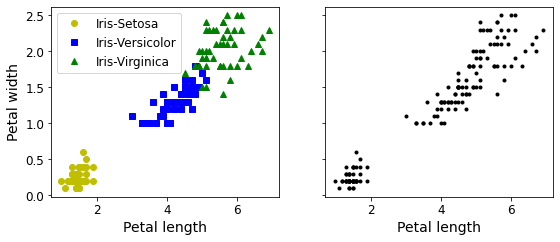

In [ ]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris-Setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris-Versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris-Virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

On the right is the same dataset, but without the labels, so you cannot use a
classification algorithm anymore. 

This is where clustering algorithms step in: many of
them can easily detect the lower-left cluster. 

It is also quite easy to see with our own
eyes, but it is not so obvious that the upper-right cluster is composed of two distinct sub-clusters.

But the dataset has two additional features (sepal length and
width), not represented here, and clustering algorithms can make good use of all features, so in fact they identify the three clusters fairly well.

A Gaussian mixture model (explained below) can actually separate these clusters pretty well (using all 4 features: petal length & width, and sepal length & width).



In [ ]:
y_pred= GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([2, 0, 1])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

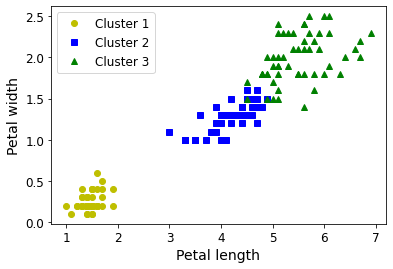

In [ ]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

And using a Gaussian mixture model, only 5 instances out of 150 are assigned to the wrong cluster.

In [ ]:
np.sum(y_pred==y)

145

In [ ]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

##K-Means

The K-Means algorithm is a simple algorithm capable of clustering
the unlabeled dataset very quickly and efficiently, often in just a few iterations.



In [ ]:
blob_centers = np.array([
    [ 0.2,  2.3],
    [-1.5 ,  2.3],
    [-2.8,  1.8],
    [-2.8,  2.8],
    [-2.8,  1.3]                     
])

blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [ ]:
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=42)

Now let's plot them:

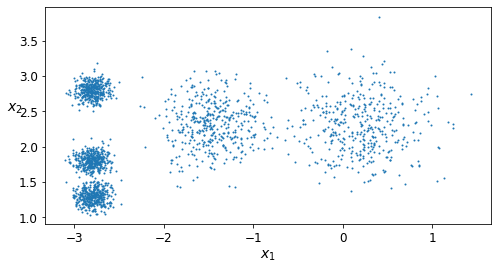

In [ ]:
plt.figure(figsize=(8, 4))
plot_clusters(X)

plt.show()

Let’s train a K-Means clusterer on this dataset. 

It will try to find each blob’s center and assign each instance to the closest blob:

In [ ]:
k = 5

kmeans = KMeans(n_clusters=5, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the five clusters. 

In the context of clustering, an
instance’s label is the index of the cluster that this instance gets assigned to by the
algorithm: this is not to be confused with the class labels in classification (remember
that clustering is an unsupervised learning task). 

The KMeans instance preserves a
copy of the labels of the instances it was trained on, available via the `labels_` instance variable:

In [ ]:
y_pred

array([2, 1, 3, ..., 1, 2, 4], dtype=int32)

In [ ]:
y_pred is kmeans.labels_

True

We can also take a look at the five centroids that the algorithm found:

In [ ]:
kmeans.cluster_centers_

array([[-2.79244799,  1.2973862 ],
       [ 0.20925539,  2.30351618],
       [-2.79846237,  2.80004584],
       [-1.4453407 ,  2.32051326],
       [-2.80372723,  1.80873739]])

You can easily assign new instances to the cluster whose centroid is closest:

In [ ]:
x_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(x_new)

array([1, 1, 2, 2], dtype=int32)

If you plot the cluster’s decision boundaries, you get a Voronoi tessellation (where each centroid is represented with an X).

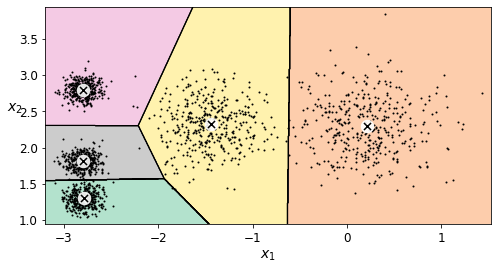

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

plt.show()

The vast majority of the instances were clearly assigned to the appropriate cluster, but
a few instances were probably mislabeled (especially near the boundary between the
top-left cluster and the central cluster).

Indeed, the K-Means algorithm does not
behave very well when the blobs have very different diameters because all it cares
about when assigning an instance to a cluster is the distance to the centroid.

Instead of assigning each instance to a single cluster, which is called hard clustering, it
can be useful to give each instance a score per cluster, which is called soft clustering.
The score can be the distance between the instance and the centroid; conversely, it
can be a similarity score (or affinity), such as the Gaussian Radial Basis Function.

In the KMeans class, the `transform()` method measures
the distance from each instance to every centroid:

In [ ]:
kmeans.transform(x_new)

array([[2.87948466, 0.36865958, 2.91057812, 1.48045212, 2.81024337],
       [5.8349053 , 2.80720102, 5.85339553, 4.45688037, 5.80687792],
       [1.71521765, 3.28396253, 0.28389977, 1.69666372, 1.20732332],
       [1.22039247, 3.21526454, 0.36144837, 1.56498595, 0.7185868 ]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [ ]:
np.linalg.norm(np.tile(x_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.87948466, 0.36865958, 2.91057812, 1.48045212, 2.81024337],
       [5.8349053 , 2.80720102, 5.85339553, 4.45688037, 5.80687792],
       [1.71521765, 3.28396253, 0.28389977, 1.69666372, 1.20732332],
       [1.22039247, 3.21526454, 0.36144837, 1.56498595, 0.7185868 ]])

If you have a high-dimensional
dataset and you transform it this way, you end up with a `k-dimensional` dataset: this
transformation can be a very efficient nonlinear dimensionality reduction technique.

###The K-Means algorithm

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [ ]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", max_iter=1, random_state=42)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", max_iter=2, random_state=42)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", max_iter=3, random_state=42)

kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=42)

And let's plot this:

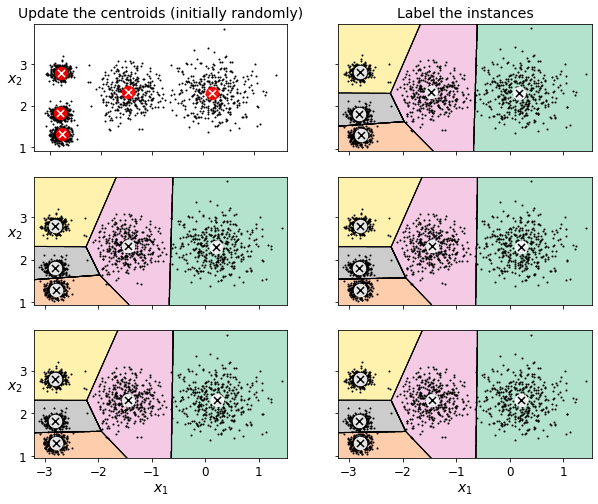

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

You can see the algorithm in action, the centroids are initialized randomly
(top left), then the instances are labeled (top right), then the centroids are
updated (center left), the instances are relabeled (center right), and so on. 

As you can
see, in just three iterations, the algorithm has reached a clustering that seems close to
optimal.

Although the algorithm is guaranteed to converge, it may not converge to the right
solution (i.e., it may converge to a local optimum): whether it does or not depends on
the centroid initialization.

### K-Means Variability

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

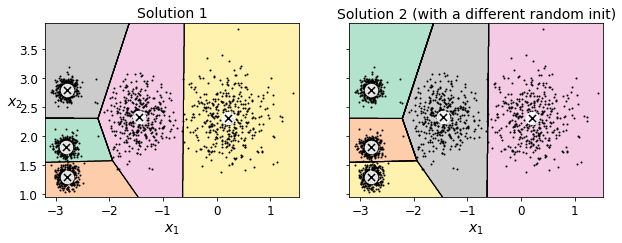

In [ ]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X, "Solution 1", "Solution 2 (with a different random init)")
plt.show()

### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

In [ ]:
kmeans.inertia_

213.42177131258904

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [ ]:
x_dist = kmeans.transform(X)
np.sum(x_dist[np.arange(len(x_dist)), kmeans.labels_] ** 2)

213.4217713125898

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_great is better_" rule.

In [ ]:
kmeans.score(X)

-213.42177131258904

### Multiple Centroid Initializations Methods

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. 

For example, here are the inertias of the two "bad" models shown in the previous figure:

In [ ]:
kmeans_rnd_init1.inertia_

213.42177131258904

In [ ]:
kmeans_rnd_init2.inertia_

213.42177131258904

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [ ]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, n_init=1, random_state=11)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

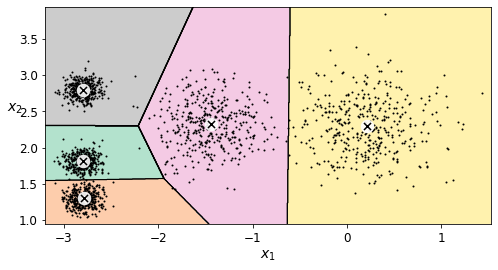

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### K-Means++

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

In [ ]:
KMeans()

KMeans()

In [ ]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])

kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

213.42177131258904

### Accelerated K-Means

The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

To use Elkan's variant of K-Means, just set `algorithm="elkan"`. Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.

In [ ]:
%timeit -n 50 KMeans(algorithm="elkan").fit(X)

50 loops, best of 5: 67.2 ms per loop


In [ ]:
%timeit -n 50 KMeans(algorithm="full").fit(X)

50 loops, best of 5: 38.9 ms per loop


### Mini-Batch K-Means

Scikit-Learn also implements a variant of the K-Means algorithm that supports mini-batches (see [this paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [ ]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [ ]:
minibatch_kmeans.inertia_

213.5721496497501

If the dataset does not fit in memory, the simplest option is to use the `memmap` class, just like we did for incremental PCA:

In [ ]:
filename = "my_mnist.data"
m, n = 50000, 28*28
x_mm = np.memmap(filename, dtype="float32", mode="write", shape=(m, n))

In [ ]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(x_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

If your data is so large that you cannot use `memmap`, things get more complicated. 

Let's start by writing a function to load the next batch (in real life, you would load the data from disk):

In [ ]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Now we can train the model by feeding it one batch at a time. 

We also need to implement multiple initializations and keep the model with the lowest inertia:

In [ ]:
np.random.seed(42)

In [ ]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [ ]:
best_kmeans.score(X)

-213.4701266350264

Mini-batch K-Means is much faster than regular K-Means:

In [ ]:
%timeit KMeans(n_clusters=5).fit(X)

1 loop, best of 5: 351 ms per loop


In [ ]:
%timeit MiniBatchKMeans(n_clusters=5).fit(X)

The slowest run took 38.32 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 17.8 ms per loop


That's *much* faster! However, its performance is often lower (higher inertia), and it keeps degrading as _k_ increases. 

Let's plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means:

In [ ]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

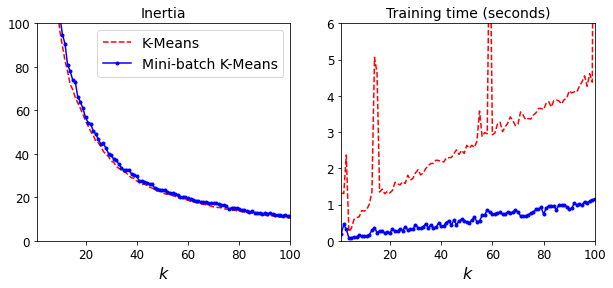

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
#plt.ylabel("Inertia", fontsize=14)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
#plt.ylabel("Training time (seconds)", fontsize=14)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])
#plt.legend(fontsize=14)

plt.show()

### Finding the optimal number of clusters

So far, we have set the number of clusters k to 5 because it was obvious by looking at
the data that this was the correct number of clusters. 

But in general, it will not be so
easy to know how to set k, and the result might be quite bad if you set it to the wrong
value.

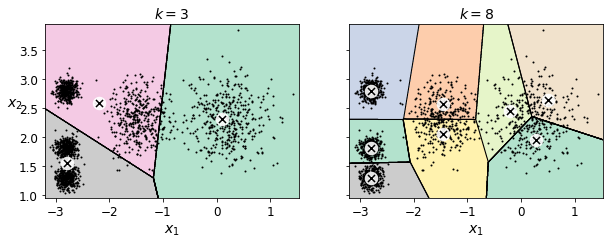

In [ ]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")

plt.show()

Ouch, these two models don't look great. What about their inertias?

In [ ]:
kmeans_k3.inertia_

662.943234078161

In [ ]:
kmeans_k8.inertia_

122.21669990809283

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. 

However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

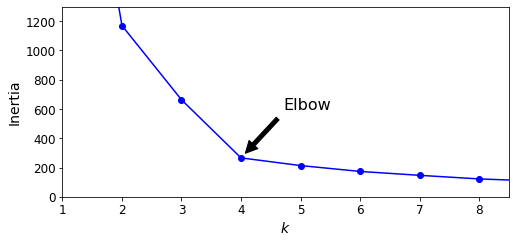

In [ ]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])

plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. 

Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

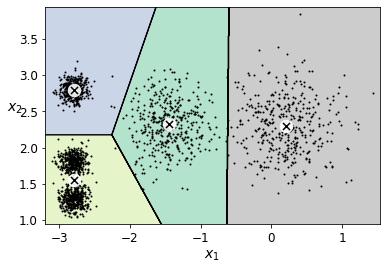

In [ ]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). 

The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [ ]:
silhouette_score(X, kmeans.labels_)

0.656578194104489

In [ ]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

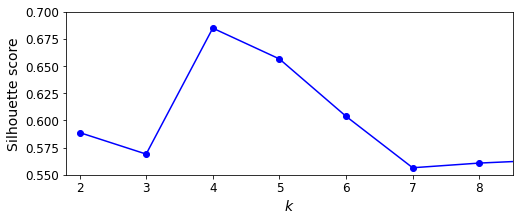

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])

plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

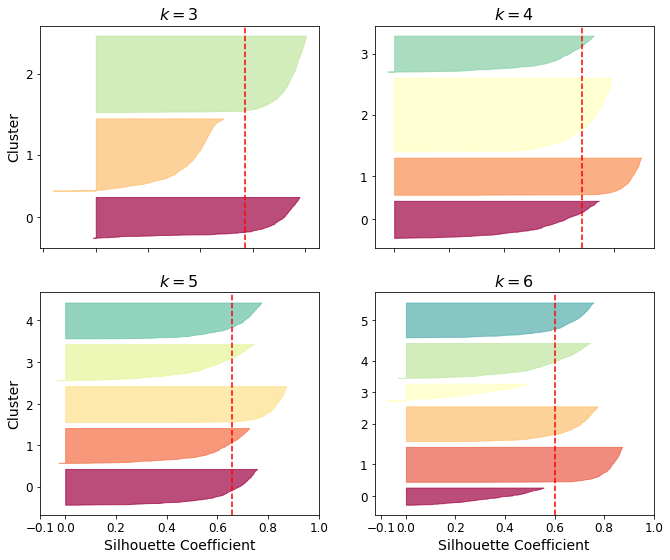

In [ ]:
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

## Limits of K-Means

Despite its many merits, most notably being fast and scalable, K-Means is not perfect.

As we saw, it is necessary to run the algorithm several times to avoid suboptimal solutions,
plus you need to specify the number of clusters, which can be quite a hassle.

Moreover, K-Means does not behave very well when the clusters have varying sizes, different densities, or nonspherical shapes.

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

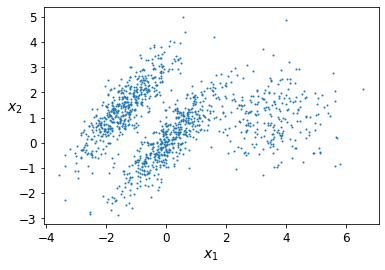

In [ ]:
plot_clusters(X)

In [ ]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

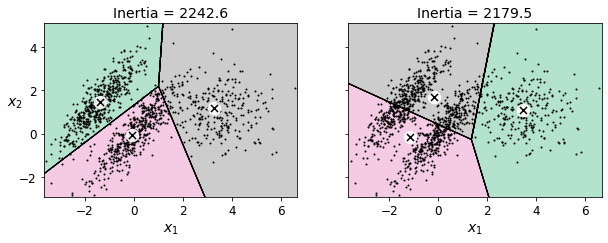

In [ ]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

As you can see, neither of these solutions is any good. The solution on the left is better,
but it still chops off 25% of the middle cluster and assigns it to the cluster on the
right. 

The solution on the right is just terrible, even though its inertia is lower. So,
depending on the data, different clustering algorithms may perform better. On these
types of elliptical clusters, Gaussian mixture models work great.